In [25]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [47]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [28]:
dataset = 'adult'
learner_type = 'ANN'
loader_func = load_adult

In [29]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [30]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [31]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Nets

In [32]:
# Build a KerasClassifier for use with scikit-learn
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


n_features = X_train.shape[1]


def build_keras_clf(hidden_layer_sizes=(10,10), learning_rate_init=0.01, momentum=0.8):
    """This function builds a Keras model for use with scikit's GridSearch"""
    if not isinstance(hidden_layer_sizes, tuple):
        hidden_layer_sizes = (hidden_layer_sizes,)
    
    model = Sequential()
    
    model.add(Dense(units=n_features, input_shape=(n_features,), activation='relu'))
    
    for layer_size in hidden_layer_sizes:
        assert layer_size > 0
        model.add(Dense(units=layer_size, activation='relu'))
    
    # Add output layer
    model.add(Dense(units=1, activation='sigmoid'))
        
    sgd = SGD(lr=learning_rate_init, momentum=momentum, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])
    
    return model

clf = KerasClassifier(build_fn=build_keras_clf, verbose=0)

### GridSearch for model complexity curves

In [33]:
layer_sizes = [
    (10,10),
    (50,50),
    (100,100),
]

param_grid = {
    'hidden_layer_sizes': layer_sizes,
    'learning_rate_init': [0.01, .1, .2],
    'momentum': [0.7, 0.8, 0.9],
    'epochs': [10, 100, 200]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=1,
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

In [46]:
save_search_result(grid_search, dataset, learner_type)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### Model Complexity Analysis

In [34]:
# res = load_best_search(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['0.779_adult_ANN_2018-09-19_07-29-04-00.pkl']
Returning results for the highest-scoring-file: 0.779_adult_ANN_2018-09-19_07-29-04-00.pkl


mean_fit_time  std_fit_time  mean_score_time  \
epochs hidden_layer_sizes                                                 
10     (10, 10)                 6.488153      0.154864         0.153348   
100    (10, 10)                60.777707      3.642018         0.228799   
200    (100, 100)             176.070050      6.563279         0.342656   
10     (100, 100)               8.540566      1.334536         0.235208   
100    (100, 100)              78.728125      1.808678         0.269353   
200    (10, 10)               136.321786      5.253953         0.299288   
1      (100, 100)               1.059732      0.119630         0.133583   
       (10, 10)                 0.853862      0.079920         0.093463   

                           std_score_time  mean_test_score  std_test_score  \
epochs hidden_layer_sizes                                                    
10     (10, 10)                  0.007610         0.778935        0.018942   
100    (10, 10)                  0.029582         0.769685        0.021518   
200    (100, 100)                0.015568         0.768874        0.016251   
10     (100, 100)                0.041119         0.767369        0.014443   
100    (100, 100)                0.008071         0.761276        0.030352   
200    (10, 10)                  0.015630         0.746393        0.018945   
1      (100, 100)                0.015618         0.702169        0.022820   
       (10, 10)                  0.004646         0.552751        0.052976   

                           rank_test_score  mean_train_score  std_train_score  
epochs hidden_layer_sizes                                                      
10     (10, 10)                          1          0.787040         0.014155  
100    (10, 10)                          2          0.828078         0.025156  
200    (100, 100)                        3          0.865496         0.015392  
10     (100, 100)                        4          0.773411         0.014974  
100    (100, 100)                        5          0.820275         0.038654  
200    (10, 10)                          6          0.833358         0.023133  
1      (100, 100)                        7          0.701629         0.015753  
       (10, 10)                          8          0.557506         0.057529

In [35]:
# small_network = res_df.xs((10,10), level='hidden_layer_sizes')
# large_network = res_df.xs((100,100), level='hidden_layer_sizes')

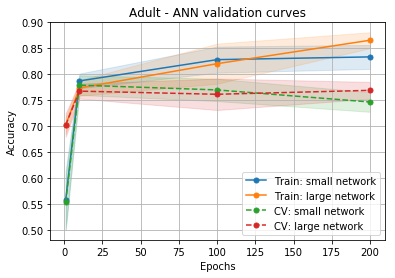

In [36]:
# # Plot combined validation curve
# plot_means_w_stds(
#     means=(small_network['mean_train_score'], large_network['mean_train_score'], small_network['mean_test_score'], large_network['mean_test_score']),
#     stds=(small_network['std_train_score'], large_network['std_train_score'], small_network['std_test_score'], large_network['std_test_score']),
#     xrange=param_grid['epochs'],
#     xlabel='Epochs',
#     ylabel='Accuracy',
#     series_labels=('Train: small network', 'Train: large network', 'CV: small network', 'CV: large network'),
#     title='Adult - ANN validation curves',
#     legend_kwargs={'loc': 'best'}
# )

### Timing analysis

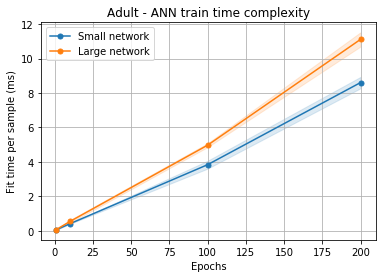

In [37]:
# means = [small_network['mean_fit_time'], large_network['mean_fit_time']]
# stds = [small_network['std_fit_time'], large_network['std_fit_time']]
# labels = ['Small network', 'Large network']

# # Calculate per-sample mean
# n_samples = X_train_scaled.shape[0] * 3/4 # three-quarters of dataset was fit for 4-fold validation
# # convert to milliseconds
# means_per_samp = [mean / n_samples * 1000 for mean in means]
# stds_per_samp = [std / n_samples * 1000 for std in stds]

# plot_means_w_stds(
#     means_per_samp,
#     stds_per_samp,
#     param_grid['epochs'],
#     series_labels=labels,
#     title='Adult - ANN train time complexity',
#     legend_kwargs={'loc': 'best'},
#     ylabel='Fit time per sample (ms)',
#     xlabel='Epochs',
#     linestyles=['-']*2,
# #     fig_kwargs={'figsize': (10,6)},
# )

## Learning Curves for best learner

### What is the best learner?

In [38]:
best_params = res['params'][np.argmax(res['mean_test_score'])]
clf = KerasClassifier(build_fn=build_keras_clf, **best_params)
clf.get_params()

{'epochs': 10,
 'hidden_layer_sizes': (10, 10),
 'build_fn': <function __main__.build_keras_clf(hidden_layer_sizes=(10, 10), learning_rate_init=0.01, momentum=0.8)>}

Epoch 1/10
1583/1583 [==============================] - 1s 403us/step - loss: 0.1994 - acc: 0.7536
Epoch 2/10
1583/1583 [==============================] - 0s 121us/step - loss: 0.1774 - acc: 0.7536
Epoch 3/10
1583/1583 [==============================] - 0s 99us/step - loss: 0.1684 - acc: 0.7536
Epoch 4/10
1583/1583 [==============================] - 0s 102us/step - loss: 0.1610 - acc: 0.7536
Epoch 5/10
1583/1583 [==============================] - 0s 120us/step - loss: 0.1549 - acc: 0.7536
Epoch 6/10
1583/1583 [==============================] - 0s 96us/step - loss: 0.1500 - acc: 0.7536
Epoch 7/10
1583/1583 [==============================] - 0s 122us/step - loss: 0.1462 - acc: 0.7517
Epoch 8/10
1583/1583 [==============================] - 0s 100us/step - loss: 0.1437 - acc: 0.7599
Epoch 9/10
1583/1583 [==============================] - 0s 87us/step - loss: 0.1418 - acc: 0.7808
Epoch 10/10
1583/1583 [==============================] - 0s 94us/step
Epoch 1/10
3166/3166 [====================

12667/12667 [==============================] - 2s 129us/step - loss: 0.1164 - acc: 0.8317
Epoch 6/10
12667/12667 [==============================] - 2s 126us/step - loss: 0.1147 - acc: 0.8345
Epoch 7/10
12667/12667 [==============================] - 1s 78us/step - loss: 0.1133 - acc: 0.8361
Epoch 8/10
12667/12667 [==============================] - 1s 82us/step - loss: 0.1125 - acc: 0.8386
Epoch 9/10
12667/12667 [==============================] - 1s 106us/step - loss: 0.1109 - acc: 0.8402
Epoch 10/10
12667/12667 [==============================] - 1s 87us/step
Epoch 1/10
14250/14250 [==============================] - 2s 160us/step - loss: 0.1666 - acc: 0.7502
Epoch 2/10
14250/14250 [==============================] - 2s 114us/step - loss: 0.1338 - acc: 0.8141
Epoch 3/10
14250/14250 [==============================] - 1s 105us/step - loss: 0.1241 - acc: 0.8233 1s 
Epoch 4/10
14250/14250 [==============================] - 2s 127us/step - loss: 0.1200 - acc: 0.8296
Epoch 5/10
14250/14250 [====

7917/7917 [==============================] - 1s 87us/step - loss: 0.1167 - acc: 0.8360
Epoch 10/10
7917/7917 [==============================] - 1s 74us/step
Epoch 1/10
9500/9500 [==============================] - 1s 137us/step - loss: 0.1774 - acc: 0.7491
Epoch 2/10
9500/9500 [==============================] - 1s 85us/step - loss: 0.1320 - acc: 0.8164
Epoch 3/10
9500/9500 [==============================] - 1s 95us/step - loss: 0.1238 - acc: 0.8253
Epoch 4/10
9500/9500 [==============================] - 1s 117us/step - loss: 0.1202 - acc: 0.8281
Epoch 5/10
9500/9500 [==============================] - 1s 118us/step - loss: 0.1181 - acc: 0.8307
Epoch 6/10
9500/9500 [==============================] - 1s 110us/step - loss: 0.1166 - acc: 0.8319
Epoch 7/10
9500/9500 [==============================] - 1s 113us/step - loss: 0.1153 - acc: 0.8339
Epoch 8/10
9500/9500 [==============================] - 1s 87us/step - loss: 0.1143 - acc: 0.8362
Epoch 9/10
9500/9500 [==============================] 

4750/4750 [==============================] - 1s 204us/step - loss: 0.1931 - acc: 0.7156
Epoch 2/10
4750/4750 [==============================] - 0s 70us/step - loss: 0.1473 - acc: 0.7773
Epoch 3/10
4750/4750 [==============================] - 0s 69us/step - loss: 0.1340 - acc: 0.8128
Epoch 4/10
4750/4750 [==============================] - 0s 72us/step - loss: 0.1274 - acc: 0.8208
Epoch 5/10
4750/4750 [==============================] - 1s 110us/step - loss: 0.1235 - acc: 0.8259
Epoch 6/10
4750/4750 [==============================] - 1s 127us/step - loss: 0.1212 - acc: 0.8244
Epoch 7/10
4750/4750 [==============================] - 0s 105us/step - loss: 0.1193 - acc: 0.8269
Epoch 8/10
4750/4750 [==============================] - 1s 155us/step - loss: 0.1177 - acc: 0.8303
Epoch 9/10
4750/4750 [==============================] - 1s 153us/step - loss: 0.1170 - acc: 0.8320
Epoch 10/10
4750/4750 [==============================] - 0s 103us/step
Epoch 1/10
6333/6333 [==============================

15834/15834 [==============================] - 2s 146us/step - loss: 0.1168 - acc: 0.8307
Epoch 5/10
15834/15834 [==============================] - 2s 144us/step - loss: 0.1150 - acc: 0.8325
Epoch 6/10
15834/15834 [==============================] - 2s 135us/step - loss: 0.1136 - acc: 0.8336
Epoch 7/10
15834/15834 [==============================] - 2s 124us/step - loss: 0.1127 - acc: 0.8367
Epoch 8/10
15834/15834 [==============================] - 2s 106us/step - loss: 0.1118 - acc: 0.8390
Epoch 9/10
15834/15834 [==============================] - 2s 126us/step - loss: 0.1110 - acc: 0.8376
Epoch 10/10
15834/15834 [==============================] - 1s 76us/step
Epoch 1/10
1583/1583 [==============================] - 2s 956us/step - loss: 0.2103 - acc: 0.7189
Epoch 2/10
1583/1583 [==============================] - 0s 174us/step - loss: 0.1758 - acc: 0.7322
Epoch 3/10
1583/1583 [==============================] - 0s 90us/step - loss: 0.1599 - acc: 0.7745
Epoch 4/10
1583/1583 [===============

11083/11083 [==============================] - 1s 125us/step - loss: 0.1143 - acc: 0.8351
Epoch 9/10
11083/11083 [==============================] - 2s 151us/step - loss: 0.1133 - acc: 0.8361
Epoch 10/10
11083/11083 [==============================] - 1s 75us/step
Epoch 1/10
12667/12667 [==============================] - 3s 217us/step - loss: 0.1642 - acc: 0.7524
Epoch 2/10
12667/12667 [==============================] - 1s 112us/step - loss: 0.1311 - acc: 0.8141
Epoch 3/10
12667/12667 [==============================] - 2s 137us/step - loss: 0.1226 - acc: 0.8252
Epoch 4/10
12667/12667 [==============================] - 1s 91us/step - loss: 0.1194 - acc: 0.8270
Epoch 5/10
12667/12667 [==============================] - 2s 125us/step - loss: 0.1175 - acc: 0.8321
Epoch 6/10
12667/12667 [==============================] - 2s 131us/step - loss: 0.1163 - acc: 0.8324
Epoch 7/10
12667/12667 [==============================] - 2s 133us/step - loss: 0.1149 - acc: 0.8333
Epoch 8/10
12667/12667 [=======

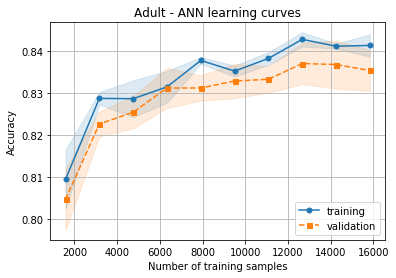

In [39]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, title='Adult - ANN learning curves')

In [45]:
save_learning_curve(dataset, learner_type, train_sizes, train_mean, train_std, test_mean, test_std)

# Test Set Performance

In [41]:
best_clf = KerasClassifier(build_fn=build_keras_clf, **best_params)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = balanced_accuracy(y_test, y_test_pred)
print('%.4f' % test_score)

0.7626
